<a href="https://colab.research.google.com/github/Carapet07/Data-Science-projects/blob/main/Facial_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset: https://www.kaggle.com/datasets/msambare/fer2013/data

### In this project, I will develop a facial emotion recognition model using the FER2013 dataset. This dataset contains images of human faces, each labeled with one of 7 different emotions: Angry, Disgust, Fear, Happy, Sad, Surprise, and Neutral. The data is already divided into training and testing categories, allowing for efficient model evaluation and performance measurement.

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

In [3]:
# upload kaggle's json file
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"romacarapetean","key":"a46e24d04f7f0717c08d7cd4f8fbb24e"}'}

In [4]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# download the dataset
!kaggle datasets download -d msambare/fer2013
!unzip fer2013.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

Data preprocessing including data augumentaton

In [5]:
train_dir = 'test/'
test_dir = 'train/'

print(os.listdir(train_dir))

train_datagen = ImageDataGenerator(rescale=1.0/255, rotation_range=20, zoom_range=0.2,
                                   width_shift_range=0.2, height_shift_range=0.2,
                                   horizontal_flip=True, vertical_flip=True,
                                   shear_range=20
                                   )
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(48, 48),
                                                    batch_size=32, class_mode='categorical')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(48, 48),
                                                    batch_size=32, class_mode='categorical')

['fear', 'disgust', 'neutral', 'sad', 'surprise', 'happy', 'angry']
Found 7178 images belonging to 7 classes.
Found 28709 images belonging to 7 classes.


In [6]:
num_batches = len(train_generator)
print(f"Number of batches in train_generator: {num_batches}")

Number of batches in train_generator: 225


Why the length of train_generator is only 225 whereas above we can see 'Found 7178 images belonging to 7 classes'. So it is because len function works on a generator object and returns the total number of batches

For a directory with N images and a batch_size of B, the number of batches is aproximately N/B.


7178 / 32 = 224.31

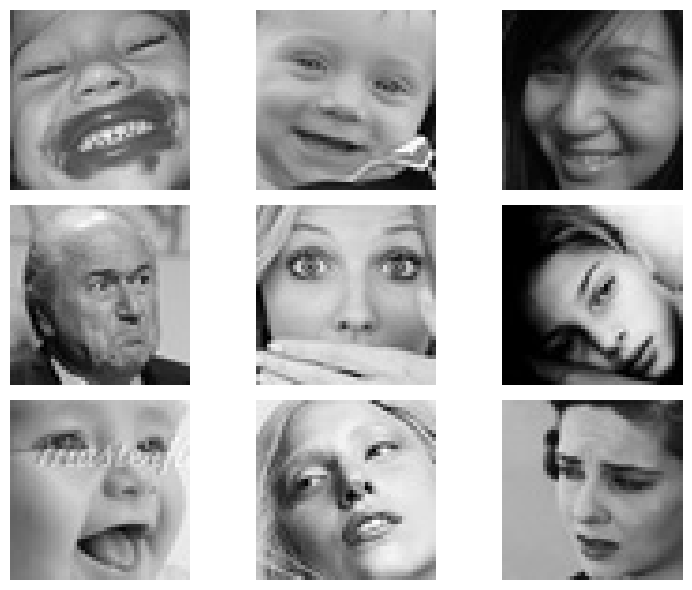

In [7]:
rows, cols = 3, 3

fig, axes = plt.subplots(rows, cols, figsize=(8, 6))

imgs, labels = next(test_generator)

for i, ax in enumerate(axes.flat):
  if i < len(imgs): # check if we don't exceed the batch size
    ax.imshow(imgs[i])
    ax.axis('off')


plt.tight_layout()
plt.show()

Check the number of channels in the images

In [8]:
batch = next(train_generator)
images, labels = batch

print(images.shape)

(32, 48, 48, 3)


Make the model

I will use residual connection which allow us to slide the gradients through the model to save its weights

The bias term in the layers will be turned off because I will use BatchNormalization which includes its own offset(Beta), making the layer's bias redundant

GlobalAveragePooling2D layer replaces Flatten. Why? Flatten layer produces a large of features that often require a Dense layer afterward, resulting in a high number of parameters. GlobalAveragePooling drastically reduces the number of features, making the model lighter and less prone to overfitting


In [9]:
inputs = layers.Input(shape=(48, 48, 3))
x = layers.Conv2D(filters=32, kernel_size=5, activation='relu', use_bias=False)(inputs)

for filters in [32, 64, 128]:
  residual = x # add residual connection

  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)
  x = layers.Conv2D(filters, kernel_size=3, activation='relu', padding='same', use_bias=False)(x)

  x = layers.MaxPool2D(3, padding='same', strides=2)(x)

  residual = layers.Conv2D(filters, 1, strides=2, padding='same', use_bias=False)(residual)
  x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(7, activation='softmax')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 48, 48, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 44, 44, 32)     │          2,400 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 44, 44, 32)     │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 44, 44, 32)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 44, 44, 32)     │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 22, 22, 32)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 22, 22, 32)     │          1,024 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 22, 22, 32)     │              0 │ max_pooling2d[0][0],   │
│                           │                        │                │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 22, 22, 32)     │            128 │ add[0][0]              │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 22, 22, 32)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 22, 22, 64)     │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 11, 11, 64)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 11, 11, 64)     │          2,048 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 11, 11, 64)     │              0 │ max_pooling2d_1[0][0], │
│                           │                        │                │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 11, 11, 64)     │            256 │ add_1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 11, 11, 64)     │              0 │ batch_normalization_2… │
├──────────────────────

 Total params: 116,455 (454.90 KB)

 Trainable params: 116,199 (453.90 KB)

 Non-trainable params: 256 (1.00 KB)

In [10]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(train_generator, validation_data=test_generator, epochs=20,
          steps_per_epoch=len(train_generator), validation_steps=len(test_generator))

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


225/225 ━━━━━━━━━━━━━━━━━━━━ 35s 120ms/step - accuracy: 0.1993 - loss: 2.0297 - val_accuracy: 0.2515 - val_loss: 1.8184
Epoch 2/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 89us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/20


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


225/225 ━━━━━━━━━━━━━━━━━━━━ 29s 92ms/step - accuracy: 0.2334 - loss: 1.8196 - val_accuracy: 0.2529 - val_loss: 1.9558
Epoch 4/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 79us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - accuracy: 0.2583 - loss: 1.7994 - val_accuracy: 0.2535 - val_loss: 2.1441
Epoch 6/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 57us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 21s 89ms/step - accuracy: 0.2620 - loss: 1.7728 - val_accuracy: 0.2527 - val_loss: 3.9033
Epoch 8/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 62us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.2676 - loss: 1.7668 - val_accuracy: 0.1865 - val_loss: 1.8372
Epoch 10/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 11/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.2841 - loss: 1.7458 - val_accuracy: 0.29